In [1]:
import pandas as pd 
import numpy as np 
import csv
import math 
#from fs_gcsfs import GCSFS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
#from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
import re 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

## Data

Datos demograficos, sociales, financieros y de negocio para la prediccion de aceptación de una tarjeta de credito

In [2]:
data = pd.read_csv("/home/jupyter/prueba_banco/data/insumo/train.csv", header =0 )

# DATA ANALYSIS

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23099 entries, 0 to 23098
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  23099 non-null  int64  
 1   Edad                23099 non-null  int64  
 2   Tipo_Trabajo        23099 non-null  object 
 3   Estado_Civil        23099 non-null  object 
 4   Educacion           23099 non-null  object 
 5   mora                23099 non-null  object 
 6   Vivienda            23099 non-null  object 
 7   Consumo             23099 non-null  object 
 8   Contacto            23099 non-null  object 
 9   Mes                 23099 non-null  object 
 10  Dia                 23099 non-null  object 
 11  Campana             23099 non-null  int64  
 12  Dias_Ultima_Camp    23099 non-null  int64  
 13  No_Contactos        23099 non-null  int64  
 14  Resultado_Anterior  23099 non-null  object 
 15  emp_var_rate        23099 non-null  float64
 16  cons

In [4]:
columns = list(data.columns)
for i in range(len(columns)):
    col1 = columns[i]
    print(col1, data[col1].isnull().sum())

ID 0
Edad 0
Tipo_Trabajo 0
Estado_Civil 0
Educacion 0
mora 0
Vivienda 0
Consumo 0
Contacto 0
Mes 0
Dia 0
Campana 0
Dias_Ultima_Camp 0
No_Contactos 0
Resultado_Anterior 0
emp_var_rate 0
cons_price_idx 0
cons_conf_idx 0
euribor3m 0
nr_employed 0
y 0


> La data no contiene valores nulos y contiene 9 variables categoricas y las restantes numericas

In [5]:
# Check balance de la data

data['y'].value_counts()

0    20509
1     2590
Name: y, dtype: int64

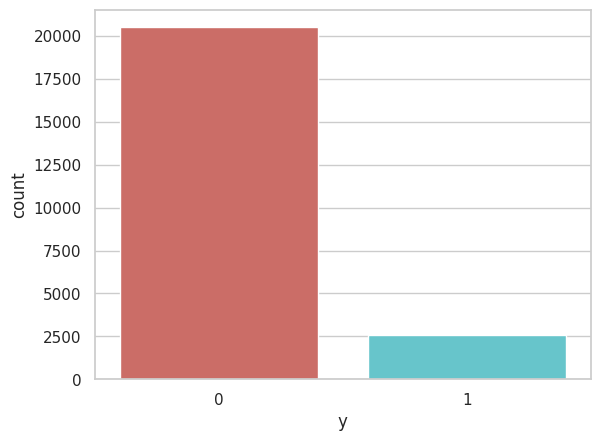

In [6]:
sns.countplot(x='y', data=data, palette='hls')
plt.show()

In [7]:
count_no_sub = len(data[data['y']==0])
count_sub = len(data[data['y']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of 0 is", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of 1 is", pct_of_sub*100)

percentage of 0 is 88.7873933936534
percentage of 1 is 11.212606606346595


>La data no esta balanceada debido a que la relación en la variable de salida es de 89:11

In [8]:
#obtenemos solo las variables categoricas en un DF
df_categoricas = data.select_dtypes(include=[object])

In [9]:
df_categoricas

,Tipo_Trabajo,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Mes,Dia,Resultado_Anterior
0,servicios,casado,bachillerato,unknown,no,no,telefono fijo,may,mon,sin contacto
1,servicios,casado,bachillerato,no,si,no,telefono fijo,may,mon,sin contacto
2,administrador negocio,casado,primaria,no,no,no,telefono fijo,may,mon,sin contacto
3,servicios,casado,bachillerato,no,no,si,telefono fijo,may,mon,sin contacto
4,servicios,single,bachillerato,no,si,no,telefono fijo,may,mon,sin contacto
...,...,...,...,...,...,...,...,...,...,...
23094,desempleado,soltero,preescolar,no,si,no,celular,nov,fri,satisfactorio
23095,empleado,casado,Estudiante Universitario,no,no,no,celular,nov,fri,sin contacto
23096,pensionado,casado,pregrado,no,si,no,celular,nov,fri,sin contacto
23097,tecnico,casado,Estudiante Universitario,no,no,no,celular,nov,fri,sin contacto


In [10]:
columns = list(df_categoricas.columns)
for i in range(len(columns)):
    unico= df_categoricas[columns[i]].unique()
    print(columns[i])
    print(unico)
    print(len(unico))
    print("============================")

Tipo_Trabajo
['servicios' 'administrador negocio' 'empleado' 'pensionado' 'tecnico'
 'vendedor ambulante' 'emprendedor' 'ama de casa' 'Vive de los arriendos'
 'desempleado' 'unknown' 'estudiante']
12
Estado_Civil
['casado' 'single' 'soltero' 'divorced' 'divorciado' 'unknown']
6
Educacion
['bachillerato' 'primaria' 'unknown' 'bachillerato incompleto' 'pregrado'
 'preescolar' 'Estudiante Universitario' 'Ninguno']
8
mora
['unknown' 'no' 'si']
3
Vivienda
['no' 'si' 'unknown']
3
Consumo
['no' 'si' 'unknown']
3
Contacto
['telefono fijo' 'celular']
2
Mes
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
10
Dia
['mon' 'tue' 'wed' 'thu' 'fri']
5
Resultado_Anterior
['sin contacto' 'fallido' 'satisfactorio']
3


> Al evaluar las variables categoricas se observa que existen 3 tipos de variables diferentes:
> 1. ordinal: Variables que contienen un claro orden de categoria como lo son: "Estado_Civil","Educacion", "mora","Vivienda","Consumo","Contacto","Resultado_Anterior"
> 2. nominal: Tipo_Trabajo
> 3. periodicas = dia y mes

# DATA CLEANING

> Se encuentra redundancia entre españo e ingles en la feature Estado_Civil y problemas de mayusculas en la feature eduacion. se crea la funcion clean_categorical_columns para estandarizar la data

In [11]:
def clean_categorical_columns(x):
    x = x.lower()
    if x == "divorced":
        x = "divorciado"
    elif x =="single":
        x = "soltero"
    else:
        x = x
    return x

In [12]:
columns_to_clean = ["Estado_Civil", "Educacion"]

for columns_clean in columns_to_clean :
    df_categoricas[columns_clean] = df_categoricas[columns_clean].apply(clean_categorical_columns)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
columns = list(df_categoricas.columns)
for i in range(len(columns)):
    unico= df_categoricas[columns[i]].unique()
    print(columns[i])
    print(unico)
    print(len(unico))
    print("============================")

Tipo_Trabajo
['servicios' 'administrador negocio' 'empleado' 'pensionado' 'tecnico'
 'vendedor ambulante' 'emprendedor' 'ama de casa' 'Vive de los arriendos'
 'desempleado' 'unknown' 'estudiante']
12
Estado_Civil
['casado' 'soltero' 'divorciado' 'unknown']
4
Educacion
['bachillerato' 'primaria' 'unknown' 'bachillerato incompleto' 'pregrado'
 'preescolar' 'estudiante universitario' 'ninguno']
8
mora
['unknown' 'no' 'si']
3
Vivienda
['no' 'si' 'unknown']
3
Consumo
['no' 'si' 'unknown']
3
Contacto
['telefono fijo' 'celular']
2
Mes
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
10
Dia
['mon' 'tue' 'wed' 'thu' 'fri']
5
Resultado_Anterior
['sin contacto' 'fallido' 'satisfactorio']
3


In [14]:
#Obtenemos solo las variables numericas en otro DF
df_numeric = data.select_dtypes(exclude=[object])
df_numeric

,ID,Edad,Campana,Dias_Ultima_Camp,No_Contactos,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,1,57,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
1,2,37,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
2,3,40,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
3,4,56,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
4,7,25,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...
23094,32963,29,1,9,1,-1.1,94767.0,-50.8,1028.0,4963.6,0
23095,32964,46,1,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,0
23096,32965,56,2,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,0
23097,32966,44,1,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,1


# DATA PREPROCESSING 

### Variables periodicas 

> Al ser vairables periodicas podemos representar cada una de ellas en un espacio de senos y cosenos.

In [15]:
def numeric_months(month):
    
    if month == "ene":
        month = 1
    elif month == "feb":
        month = 2
    elif month == "mar":
        month = 3
    elif month == "apr":
        month = 4
    elif month == "may":
        month = 5
    elif month == "jun":
        month = 6
    elif month == "jul":
        month = 7
    elif month == "ago":
        month = 8
    elif month == "sep":
        month = 9
    elif month == "oct":
        month = 10
    elif month == "nov":
        month = 11
    else:
        month = 5
    return month

def numeric_days(day):
    
    if day == "mon":
        day = 1
    elif day == "tue":
        day = 2
    elif day == "wed":
        day = 3
    elif day == "thu":
        day = 4
    elif day == "fri":
        day = 5
    elif day == "sat":
        day = 6
    else:
        day = 7
    return day

def days_to_cosenos(df_categoricas, column):
    df_categoricas["num_"+column]= df_categoricas[column].apply(lambda x: numeric_days(str(x))) #Convierto dias a numeros
    df_categoricas["norm_" + column] = 2 * math.pi * df_categoricas["num_"+column] / df_categoricas["num_"+column].max() #Normalizamos los valores de las columnas en un cilo de 0-2pi

    df_categoricas["cos_"+ column] = np.cos(df_categoricas["norm_" + column]) #Calculo el coseno para los valores normalizados 
    df_categoricas["sin_"+ column] = np.sin(df_categoricas["norm_" + column]) #Calculo el seno para los valores normalizados 
    
    return df_categoricas 


def months_to_cosenos(df_categoricas, column):
    df_categoricas["num_"+column]= df_categoricas[column].apply(lambda x: numeric_months(str(x))) #Convierto meses a numeros
    df_categoricas["norm_" + column] = 2 * math.pi * df_categoricas["num_"+column] / df_categoricas["num_"+column].max() #Normalizamos los valores de las columnas en un cilo de 0-2pi

    df_categoricas["cos_"+ column] = np.cos(df_categoricas["norm_" + column]) #Calculo el coseno para los valores normalizados 
    df_categoricas["sin_"+ column] = np.sin(df_categoricas["norm_" + column]) #Calculo el seno para los valores normalizados 
    
    return df_categoricas 

In [16]:
df_categoricas = days_to_cosenos(df_categoricas, "Dia")
columns_delete1 = ["norm_Dia", "Dia","num_Dia"] #columnas a eliminar debido a que fueron creadas temporalmente
df_categoricas = df_categoricas.drop(columns_delete1,1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [17]:
df_categoricas = months_to_cosenos(df_categoricas, "Mes")
columns_delete2 = ["norm_Mes", "Mes","num_Mes"] #columnas a eliminar debido a que fueron creadas temporalmente
df_categoricas = df_categoricas.drop(columns_delete2,1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df_categoricas

,Tipo_Trabajo,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,sin_Mes
0,servicios,casado,bachillerato,unknown,no,no,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
1,servicios,casado,bachillerato,no,si,no,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
2,administrador negocio,casado,primaria,no,no,no,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
3,servicios,casado,bachillerato,no,no,si,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
4,servicios,soltero,bachillerato,no,si,no,telefono fijo,sin contacto,0.309017,9.510565e-01,-0.959493,2.817326e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
23094,desempleado,soltero,preescolar,no,si,no,celular,satisfactorio,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23095,empleado,casado,estudiante universitario,no,no,no,celular,sin contacto,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23096,pensionado,casado,pregrado,no,si,no,celular,sin contacto,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23097,tecnico,casado,estudiante universitario,no,no,no,celular,sin contacto,1.000000,-2.449294e-16,1.000000,-1.133108e-15


### Categorical variables (ONE HOT ENCODING)

> Se aplica one hot enconding a las variables que no tienen una categoria clara o estandar

In [19]:
encoder_columns =["Tipo_Trabajo"]

suma = 0
for i in range(len(encoder_columns)):
    suma = suma + len(df_categoricas[encoder_columns[i]].unique())
    print(encoder_columns[i], len(df_categoricas[encoder_columns[i]].unique()))
print("el numero de columnas nuevas es: ", suma)

Tipo_Trabajo 12
el numero de columnas nuevas es:  12


In [20]:
#obtenemos un dataframe con las variables a las que se le aplica One Hot Encoding
data_OH = df_categoricas.filter(encoder_columns)
data_OH.head()

,Tipo_Trabajo
0,servicios
1,servicios
2,administrador negocio
3,servicios
4,servicios


In [21]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) 
OH_cols = pd.DataFrame(OH_encoder.fit_transform(data_OH)) #aplicamos OH encoder a la columna
OH_cols.index = data_OH.index
OH_cols

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23094,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23095,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Categorical variables (LABEL ENCODING)

In [22]:

columns_LE = ["Estado_Civil","Educacion", "mora","Vivienda","Consumo","Contacto","Resultado_Anterior"]

# instancia de labelencoder
labelencoder = LabelEncoder()
for i in range(len(columns_LE)):    
    # Asignación de numerical values
    df_categoricas[columns_LE[i]] = labelencoder.fit_transform(df_categoricas[columns_LE[i]])
                                                                          
                                                                          
df_categoricas

,Tipo_Trabajo,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,sin_Mes
0,servicios,0,0,2,0,0,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
1,servicios,0,0,0,1,0,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
2,administrador negocio,0,6,0,0,0,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
3,servicios,0,0,0,0,1,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
4,servicios,2,0,0,1,0,1,2,0.309017,9.510565e-01,-0.959493,2.817326e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
23094,desempleado,2,4,0,1,0,0,1,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23095,empleado,0,2,0,0,0,0,2,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23096,pensionado,0,5,0,1,0,0,2,1.000000,-2.449294e-16,1.000000,-1.133108e-15
23097,tecnico,0,2,0,0,0,0,2,1.000000,-2.449294e-16,1.000000,-1.133108e-15


In [23]:
final_categoricas = df_categoricas.drop("Tipo_Trabajo",1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [24]:
#unimos cada uno de los dataframes que fueron trabajados como variables categoricas
final_categoricas = pd.concat([final_categoricas, OH_cols], axis=1)
final_categoricas.head()

,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,...,2,3,4,5,6,7,8,9,10,11
0,0,0,2,0,0,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,0,0,1,0,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,6,0,0,0,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2,0,0,1,0,1,2,0.309017,0.951057,-0.959493,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [25]:
final_categoricas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23099 entries, 0 to 23098
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Estado_Civil        23099 non-null  int64  
 1   Educacion           23099 non-null  int64  
 2   mora                23099 non-null  int64  
 3   Vivienda            23099 non-null  int64  
 4   Consumo             23099 non-null  int64  
 5   Contacto            23099 non-null  int64  
 6   Resultado_Anterior  23099 non-null  int64  
 7   cos_Dia             23099 non-null  float64
 8   sin_Dia             23099 non-null  float64
 9   cos_Mes             23099 non-null  float64
 10  sin_Mes             23099 non-null  float64
 11  0                   23099 non-null  float64
 12  1                   23099 non-null  float64
 13  2                   23099 non-null  float64
 14  3                   23099 non-null  float64
 15  4                   23099 non-null  float64
 16  5   

In [26]:
#obtenemos el DF final el cual es el concat entre el df categorical y el numerico
final_df = pd.concat([final_categoricas, df_numeric], axis=1)
final_df

,Estado_Civil,Educacion,mora,Vivienda,Consumo,Contacto,Resultado_Anterior,cos_Dia,sin_Dia,cos_Mes,...,Edad,Campana,Dias_Ultima_Camp,No_Contactos,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,0,2,0,0,1,2,0.309017,9.510565e-01,-0.959493,...,57,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
1,0,0,0,1,0,1,2,0.309017,9.510565e-01,-0.959493,...,37,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
2,0,6,0,0,0,1,2,0.309017,9.510565e-01,-0.959493,...,40,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
3,0,0,0,0,1,1,2,0.309017,9.510565e-01,-0.959493,...,56,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
4,2,0,0,1,0,1,2,0.309017,9.510565e-01,-0.959493,...,25,1,999,0,1.1,93994.0,-36.4,4857.0,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23094,2,4,0,1,0,0,1,1.000000,-2.449294e-16,1.000000,...,29,1,9,1,-1.1,94767.0,-50.8,1028.0,4963.6,0
23095,0,2,0,0,0,0,2,1.000000,-2.449294e-16,1.000000,...,46,1,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,0
23096,0,5,0,1,0,0,2,1.000000,-2.449294e-16,1.000000,...,56,2,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,0
23097,0,2,0,0,0,0,2,1.000000,-2.449294e-16,1.000000,...,44,1,999,0,-1.1,94767.0,-50.8,1028.0,4963.6,1


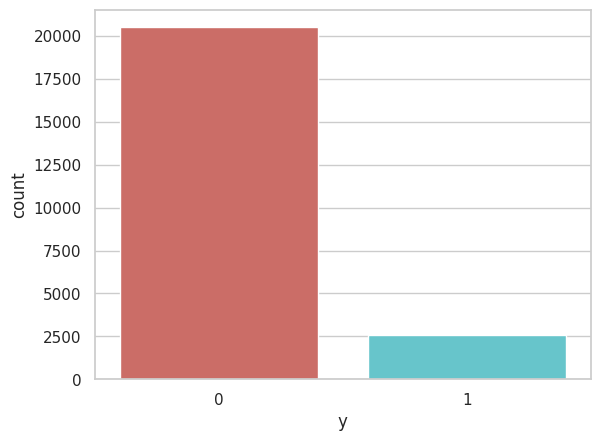

In [27]:
sns.countplot(x='y', data=final_df, palette='hls')
plt.show()

#### Balance Data

In [28]:
X = final_df.loc[:, final_df.columns != 'y']
y = final_df.loc[:, final_df.columns == 'y']

> Para solucionar el caso de los datos de salida no balanceados se hara uso de SMOTE Algorithm que basicamente opera de la siguiente manera:

>1. Crea muestras sinteticas de las clases secundaria en lugar de crear copias.
>2. Escoje uno de los k-nearest-neighbors y lo usa para crear un valor random modificado similar a una observación

In [29]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])
# we can Check the numbers of our data
print("length  oversampled  ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of 1",len(os_data_y[os_data_y['y']==1]))
print("Proportion of 0 ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of 1 ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

length  oversampled   28728
Number of 0 in oversampled data 14364
Number of 1 14364
Proportion of 0  0.5
Proportion of 1  0.5


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


> Se observa que la data ahora se encuentra balanceada

## TRAINING MODEL

Para el primer modelo se entrenara un LOGISTIC REGRESSION MODE. Para el entrenamiento de este modelo, previamente se realizara un analisis de las features con ayuda de la libreria sklearn para identificar las features que no representan un mayor peso al momento de predecir el valor "y"

#### Recursive Feature Elimination

In [30]:
data_final_vars=final_df.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]

In [31]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, step = 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

for feature in rfe.support_.nonzero():
    print(os_data_X.columns[feature])

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


Num Features: 16
Selected Features: [ True  True  True  True  True False False  True  True  True False False
 False False False False False False False False False False False  True
  True  True  True False False  True  True  True  True]
Feature Ranking: [1 1 1 1 1 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 1 1 1 1]
Index(['Estado_Civil', 'Educacion', 'mora', 'Vivienda', 'Consumo', 'cos_Dia',
       'sin_Dia', 'cos_Mes', 'ID', 'Edad', 'Campana', 'Dias_Ultima_Camp',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed'],
      dtype='object')


In [31]:
#seleccionamos las columnas que son relevantes para el entreanmiento
cols=['Estado_Civil', 'Educacion', 'mora', 'Vivienda', 'Consumo', 'cos_Dia',
       'sin_Dia', 'cos_Mes', 'ID', 'Edad', 'Campana', 'Dias_Ultima_Camp',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
X=os_data_X[cols]
y=os_data_y['y']

#### Implementacion del modelo

In [32]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.516903
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.254     
Dependent Variable: y                AIC:              29731.1613
Date:               2023-01-07 01:28 BIC:              29863.4113
No. Observations:   28728            Log-Likelihood:   -14850.   
Df Model:           15               LL-Null:          -19913.   
Df Residuals:       28712            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Estado_Civil     -0.3173   0.0187 -16.9506 0.0000 -0.3540 -0.2806
Educacion        -0.0426   0.0067  -6.3592 0.0000 -0.0558 -0.0295


> los p-values para cada una de las features seleccionadas es bajo, al igual que el Std. Error por consiguiente se mantiene la selección de features

## LOGISTIC REGRESSION MODEL FITTING WITH BALANCE

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [35]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.72


### Analisis por matriz de confusion

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[3116 1146]
 [1266 3091]]


> El resultado demuestra que tenemos 3116 + 3091 Predicciones correctas y 1266 + 1146 predicciones incorrectas

#### Analisis precision and recall 

> precision: es tp/(tp + fp) tp es el numero de verdaderos positivos y fp el numero de falsos positivos.
> recall: es tp/(tp + fn) tp es el numero de verdaderos positivos y fn el numero de falsos negaitivos.
> Una buena precision y recall e sun valor cercano a 1 y un mal valor el un resultado cercano a 0

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      4262
           1       0.73      0.71      0.72      4357

    accuracy                           0.72      8619
   macro avg       0.72      0.72      0.72      8619
weighted avg       0.72      0.72      0.72      8619



## LOGISTIC REGRESSION MODEL FITTING WITHOUT BALANCE

In [55]:
dataset = final_df.values
X1 = dataset[:, :-1]
y1 = dataset[:,-1]

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [48]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


### Analisis por matriz de confusion

In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6054   91]
 [ 619  166]]


#### Analisis precision and recall 

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94      6145
         1.0       0.65      0.21      0.32       785

    accuracy                           0.90      6930
   macro avg       0.78      0.60      0.63      6930
weighted avg       0.88      0.90      0.87      6930



### Conclusion logistic regression.
> Al trabajar con la data analizada a partir de observar el balance entre la variable de salida y el numero de registros, como tambien los pesos de cada una de las caracteristicas observamos que el modelo entrenado con este conjunto de datos presenta una precision menor a la entrenada con el conjunto de datos completo.
> Esto puede deberse a la naturaleza estocastica de los datos, donde algunas de las varibles que se tuvieron en cuenta mejoraron el performace asi como las variables que no fueron creadas. Otra razon y la mas probable es que en el segundo caso al tener una data desbalanceada este presentado un problema de OVERFITTING

## RANDOM FOREST MODEL

In [33]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
#X=os_data_X[cols]
#y=os_data_y['y']
#random forest model - preparacion de la data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#Entranamiento random forest
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# prediccion
rfc_predict = rfc.predict(X_test)

In [34]:
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc')

In [35]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[3837  425]
 [ 379 3978]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4262
           1       0.90      0.91      0.91      4357

    accuracy                           0.91      8619
   macro avg       0.91      0.91      0.91      8619
weighted avg       0.91      0.91      0.91      8619



=== All AUC Scores ===
[0.88199577 0.95864712 0.9809247  0.98562319 0.98070929 0.98363461
 0.98093633 0.98160363 0.98017333 0.98375997]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9698007934074816


### Evaluacion Random Forest

El modelo se evaluo por 3 caminos:
1. validacion cruzada.
2. Matriz de confusion.
3. classfication report.

El entrenamiento se realizo con la data completamente procesada mediante el analisis previo, donde se descartaron features que no contribuian a la prediccion y el balance de la data.

Los resultados fueron muy favorables, incluso cuando se realizo la validación cruzada podemos ver que en cada uno de los 11 entrenamientos que se realizaron sorteando la data aleatoriamente el score mas bajo fue de 0.88 dando a entender que random forest es un muy buen algoritmo para la prediccion de si un cliente quiere adquirir una nueva tarjeta de credito o no.
Como nota, el algoritmo de random forest se puede evaluar mas a detalle, debido a que se pudo haber presentado un caso de overfitting. Por esta razon se realizo la validación cruzada, pero se recomienda un analisis mas detallado.

In [45]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [61]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(16, input_shape=(16,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [62]:
X.shape[1]

16

In [63]:
# evaluate baseline model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(model=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

KeyboardInterrupt: 

In [46]:
# build a model
model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X,
                    y,
                    callbacks=[es],
                    epochs=80, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

2023-01-07 00:15:55.051827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-01-07 00:15:55.051910: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-07 00:15:55.051943: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (test-data-scientist): /proc/driver/nvidia/version does not exist
2023-01-07 00:15:55.053118: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
2299/2299 [==============================] - 7s 2ms/step - loss: 160.4856 - accuracy: 0.6288 - val_loss: 20.5970 - val_accuracy: 0.7162
Epoch 2/80
2299/2299 [==============================] - 4s 2ms/step - loss: 47.2362 - accuracy: 0.6311 - val_loss: 13.7145 - val_accuracy: 0.3954
Epoch 3/80
2299/2299 [=======

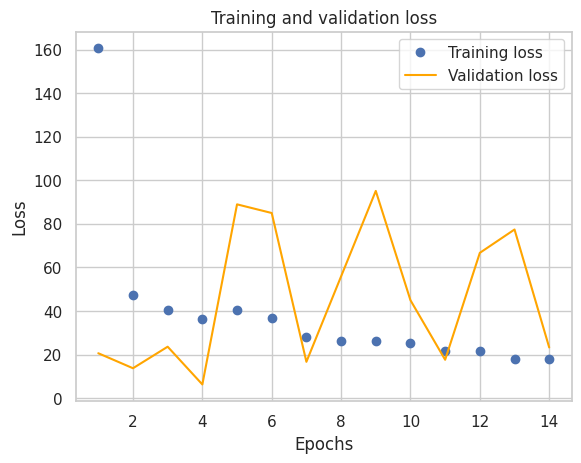

In [47]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

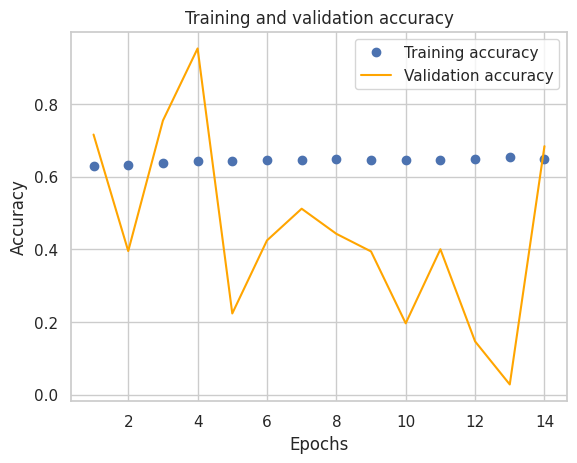

0.9531848430633545

In [48]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)